      Temperatur  Windgeschwindigkeit  Bewoelkung  Wettercode  IsWeekend  \
0        17.8375                 15.0         6.0        20.0        0.0   
3638     17.8375                 15.0         6.0        20.0        0.0   
7223     17.8375                 15.0         6.0        20.0        0.0   
1819     17.8375                 15.0         6.0        20.0        0.0   
5457     17.8375                 15.0         6.0        20.0        0.0   

      DayOfYear  WeekOfYear  Warengruppe_1  Warengruppe_2  Warengruppe_3  ...  \
0         182.0        27.0           True          False          False  ...   
3638      182.0        27.0          False          False           True  ...   
7223      182.0        27.0          False          False          False  ...   
1819      182.0        27.0          False           True          False  ...   
5457      182.0        27.0          False          False          False  ...   

      Month_7  Month_8  Month_9  Month_10  Month_11  Mon

/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 50980.8242 - mean_absolute_percentage_error: 84.9945 - val_loss: 3872.3196 - val_mean_absolute_percentage_error: 28.6269 - learning_rate: 0.0010
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4894.3403 - mean_absolute_percentage_error: 27.5409 - val_loss: 3458.8062 - val_mean_absolute_percentage_error: 24.9912 - learning_rate: 0.0010
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6455.3164 - mean_absolute_percentage_error: 25.5115 - val_loss: 3273.0530 - val_mean_absolute_percentage_error: 23.5790 - learning_rate: 0.0010
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5462.0161 - mean_absolute_percentage_error: 23.8068 - val_loss: 3113.4050 - val_mean_absolute_percentage_error: 22.2260 - learning_rate: 0.0010
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5966.1221 - mean_absolute_percentage_error: 23.4400 - val_loss: 3234.0071 - val_mean_absolute_percentage_error: 22.7490 - learning_rat

/tmp/ipykernel_20677/380933849.py:191: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mape_by_group = results_df.groupby('Warengruppe').apply(


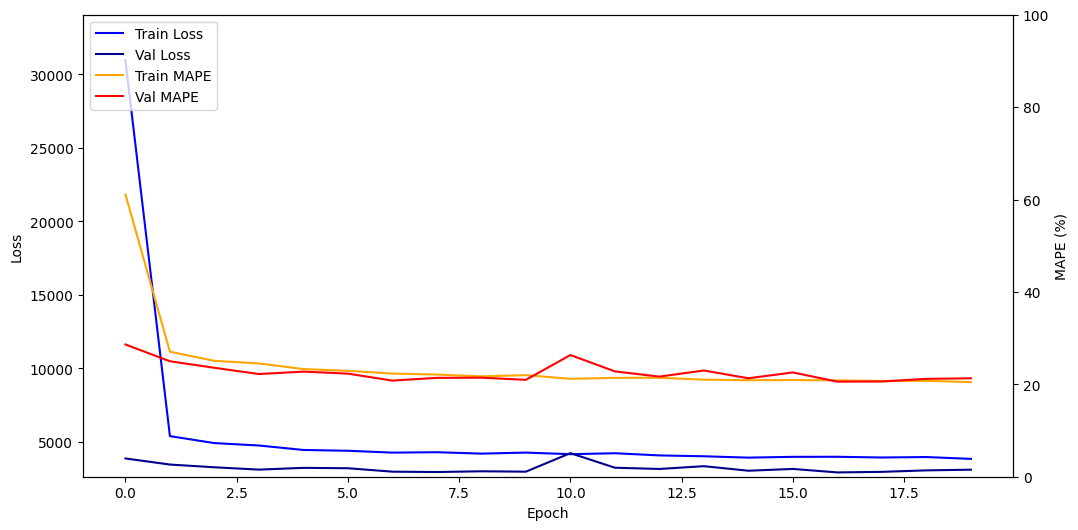

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAPE on validation set: 20.58%
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [2]:
'''

This implementation:
- Adds explicit seasonal features (DayOfYear, WeekOfYear, Season)
- Includes attention mechanism to capture long-term patterns
- Uses deeper architecture with seasonal-aware learning rate schedule

'''

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

# Load data
kiwo_url = '../../Data/kiwo.csv'
umsatz_url = '../../Data/train.csv'
wetter_url = '../../Data/wetter.csv'
test_url = '../../Data/test.csv'

df_kiwo = pd.read_csv(kiwo_url)
df_umsatz = pd.read_csv(umsatz_url)
df_wetter = pd.read_csv(wetter_url)
df_test = pd.read_csv(test_url)

# Merge data
df_train = pd.merge(df_umsatz, df_wetter, on='Datum', how='left')
df_train = pd.merge(df_train, df_kiwo, on='Datum', how='left')
df_test = pd.merge(df_test, df_wetter, on='Datum', how='left')
df_test = pd.merge(df_test, df_kiwo, on='Datum', how='left')

# Function to prepare data
def prepare_data(data):
    data['Datum'] = pd.to_datetime(data['Datum'])
    data['DayOfWeek'] = data['Datum'].dt.dayofweek
    data['Month'] = data['Datum'].dt.month
    data['DayOfYear'] = data['Datum'].dt.dayofyear
    data['WeekOfYear'] = data['Datum'].dt.isocalendar().week
    data['Season'] = (data['Month'] % 12 + 3) // 3  # 1: Spring, 2: Summer, 3: Fall, 4: Winter
    data['IsWeekend'] = (data['DayOfWeek'] >= 5).astype(float)
    data['KielerWoche'] = data['KielerWoche'].fillna(0).astype(float)
    
    numerical_cols = ['Temperatur', 'Windgeschwindigkeit', 'Bewoelkung', 'Wettercode', 
                     'IsWeekend', 'DayOfYear', 'WeekOfYear']
    knn_imputer = KNNImputer(n_neighbors=5)
    data[numerical_cols] = knn_imputer.fit_transform(data[numerical_cols])
    
    warengruppe_dummies = pd.get_dummies(data['Warengruppe'], prefix='Warengruppe')
    day_dummies = pd.get_dummies(data['DayOfWeek'], prefix='Day')
    month_dummies = pd.get_dummies(data['Month'], prefix='Month')
    season_dummies = pd.get_dummies(data['Season'], prefix='Season')
    
    feature_df = pd.concat([
        data[numerical_cols], 
        warengruppe_dummies, 
        day_dummies, 
        month_dummies,
        season_dummies
    ], axis=1)
    return feature_df


# Prepare datasets
df_train_sorted = df_train.sort_values(by='Datum')
X_train = prepare_data(df_train_sorted)
y_train = df_train_sorted['Umsatz']
X_test = prepare_data(df_test)

print(X_train.head())

# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# should be split on DATE? 
# Split data into training and validation sets
split_index = int(len(X_train) * 0.8)
X_train_seq, X_val_seq = X_train[:split_index], X_train[split_index:]
y_train_seq, y_val_seq = y_train[:split_index], y_train[split_index:]

# Reshape for LSTM (samples, time steps, features)
X_train_seq = X_train_seq.reshape(X_train_seq.shape[0], 1, X_train_seq.shape[1])
X_val_seq = X_val_seq.reshape(X_val_seq.shape[0], 1, X_val_seq.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Learning rate scheduler function
def lr_schedule(epoch, lr):
    initial_lr = 0.01  # Start with this learning rate
    decay_rate = 0.1  # Decay rate
    decay_steps = 10  # Epochs after which to decay
    return initial_lr * np.exp(-decay_rate * (epoch / decay_steps))

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
lr_scheduler = LearningRateScheduler(lr_schedule)

# Calculate class weights
sample_weights = df_train_sorted['Warengruppe'].map(
    {6: 2.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0}
)

# Add attention mechanism to LSTM
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()
        
    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                initializer='normal')
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W))
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

# Build seasonal-aware model
model = tf.keras.Sequential([
    LSTM(128, activation='relu', return_sequences=True, 
         input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.2),
    AttentionLayer(),
    Dense(32, activation='relu'),
    Dense(1)
])

def seasonal_lr_schedule(epoch, lr):
    if epoch < 50:
        return 0.001
    return 0.001 * tf.math.exp(-0.1 * ((epoch-50) // 10))

lr_scheduler = LearningRateScheduler(seasonal_lr_schedule)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             loss='mse',
             metrics=['mean_absolute_percentage_error'])

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    sample_weight=sample_weights[:split_index],
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)
###
# # Build the model 
# model = tf.keras.Sequential([
#     LSTM(64, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])), # default 50
#     Dropout(0.2), # default 0.2
#     Dense(1)
# ])

# # Compile the model
# model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=['mean_absolute_percentage_error'])

# # Train the model
# history = model.fit(
#     X_train_seq, y_train_seq, 
#     epochs=5, # was 150
#     batch_size=32, 
#     validation_data=(X_val_seq, y_val_seq), 
#     callbacks=[early_stopping, model_checkpoint, lr_scheduler]
# )

# Calculate predictions for validation set
val_predictions = model.predict(X_val_seq).flatten()

# Get original Warengruppe values for validation set
val_warengruppen = df_train_sorted.iloc[split_index:]['Warengruppe']

# Create DataFrame with actual and predicted values
results_df = pd.DataFrame({
    'Warengruppe': val_warengruppen,
    'Actual': y_val_seq,
    'Predicted': val_predictions
})

# Calculate MAPE for each Warengruppe
mape_by_group = results_df.groupby('Warengruppe').apply(
    lambda x: MeanAbsolutePercentageError()(x['Actual'], x['Predicted']).numpy()
).sort_values()

print("\nMAPE by Warengruppe:")
for warengruppe, mape in mape_by_group.items():
    print(f"Warengruppe {warengruppe}: {mape:.2f}%")

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the training and validation loss on the primary y-axis
ax1.plot(history.history['loss'], label='Train Loss', color='blue')
ax1.plot(history.history['val_loss'], label='Val Loss', color='darkblue')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Determine the minimum and maximum loss values to set the y-axis limits
min_loss = min(min(history.history['loss']), min(history.history['val_loss']))
max_loss = max(max(history.history['loss']), max(history.history['val_loss']))
ax1.set_ylim(min_loss * 0.9, max_loss * 1.1)  # Add some padding
ax1.tick_params(axis='y', labelcolor='black')

# Create a twin y-axis for the MAPE
ax2 = ax1.twinx()

# Plot the training and validation MAPE on the twin y-axis
ax2.plot(history.history['mean_absolute_percentage_error'], label='Train MAPE', color='orange')
ax2.plot(history.history['val_mean_absolute_percentage_error'], label='Val MAPE', color='red')
ax2.set_ylabel('MAPE (%)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Set the y-axis limits for the MAPE to 0-100%
ax2.set_ylim(0, 100)

# Add a legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.show()

# Load the best model
model.load_weights('best_model.keras')

# Evaluate on validation set
val_predictions = model.predict(X_val_seq).flatten()
val_mape = tf.keras.metrics.MeanAbsolutePercentageError()(y_val_seq, val_predictions).numpy()
print(f'MAPE on validation set: {val_mape:.2f}%')

# Make predictions on test set and save results
test_predictions = model.predict(X_test).flatten()
df_test['Predicted_Umsatz'] = test_predictions
df_test.to_csv('predicted_test.csv', index=False)